# Analyze (F)MNIST with `tensorflow` / `keras`

Careful: do **not** hit 'Kernel' > 'Restart & Run All', since some of the cells below take a long time to execute if you are not running the code on a GPU, so we already executed them for you.

In this notebook we compare different types of neural network architectures on the MNIST and Fashion MNIST datasets, to see how the performance improves when using a more complicated architecture. Additionally, we compare the networks to a simple logistic regression classifier from `sklearn`, which should have approximately the same accuracy as a linear FFNN (= a FFNN with only one layer mapping from the input directly to the output and no hidden layers, i.e., that has the same number of trainable parameters as the logistic regression model).

In [1]:
import os
import gzip
import random
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
# neural network libraries
import tensorflow as tf
# set random seeds before importing keras to get (at least more or less) reproducable results
random.seed(28)
np.random.seed(28)
tf.random.set_seed(28)
from tensorflow import keras
from tensorflow.keras.datasets import mnist, fashion_mnist
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras import backend as K

In [2]:
def fashion_mnist_load_local_data():
    from tensorflow.python.keras.utils.data_utils import get_file
    base = 'https://storage.googleapis.com/tensorflow/tf-keras-datasets/'
    dirname = os.path.abspath("../data/fashion-mnist") 
    files = [
        'train-labels-idx1-ubyte.gz', 'train-images-idx3-ubyte.gz',
        't10k-labels-idx1-ubyte.gz', 't10k-images-idx3-ubyte.gz'
    ]
    paths = []
    for fname in files:
        paths.append(get_file(fname, origin=base + fname, cache_subdir=dirname))

    with gzip.open(paths[0], 'rb') as lbpath:
        y_train = np.frombuffer(lbpath.read(), np.uint8, offset=8)
    with gzip.open(paths[1], 'rb') as imgpath:
        x_train = np.frombuffer(
            imgpath.read(), np.uint8, offset=16).reshape(len(y_train), 28, 28)
    with gzip.open(paths[2], 'rb') as lbpath:
        y_test = np.frombuffer(lbpath.read(), np.uint8, offset=8)
    with gzip.open(paths[3], 'rb') as imgpath:
        x_test = np.frombuffer(
            imgpath.read(), np.uint8, offset=16).reshape(len(y_test), 28, 28)
    return (x_train, y_train), (x_test, y_test)

## Load and look at the data

In [2]:
# input image dimensions
img_rows, img_cols = 28, 28
n_features = img_rows*img_cols

def load_data(use_fashion=False, reshape=False):
    # the data, split between train and test sets (load from local data folder, not ~/.keras)
    if use_fashion:
        (x_train, y_train), (x_test, y_test) = fashion_mnist_load_local_data()  # fashion_mnist.load_data()
    else:
        # might need to use mnist.load_data(path="mnist.npz") when executing on Google Colab
        (x_train, y_train), (x_test, y_test) = mnist.load_data(path=os.path.join(os.path.abspath("../data/"), "mnist.npz"))

    if K.image_data_format() == 'channels_first':
        x_train = x_train.reshape(x_train.shape[0], 1, img_rows, img_cols)
        x_test = x_test.reshape(x_test.shape[0], 1, img_rows, img_cols)
        input_shape = (1, img_rows, img_cols)
    else:
        x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 1)
        x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, 1)
        input_shape = (img_rows, img_cols, 1)

    # normalize (data is ints from 0 to 255, get them to [0, 1])
    x_train = x_train.astype('float32')
    x_test = x_test.astype('float32')
    x_train /= 255.
    x_test /= 255.
    
    if reshape:
        # transform images into regular feature vectors
        x_train = x_train.reshape(x_train.shape[0], n_features)
        x_test = x_test.reshape(x_test.shape[0], n_features)

    return x_train, x_test, y_train, y_test

def convert_cat(y_train, y_test, num_classes=10):
    # convert class vectors to binary class matrices
    y_train_cat = keras.utils.to_categorical(y_train, num_classes)
    y_test_cat = keras.utils.to_categorical(y_test, num_classes)
    return y_train_cat, y_test_cat

def plot_images(x):
    n = 10
    plt.figure(figsize=(20, 4))
    for i in range(1, n+1):
        # display original
        ax = plt.subplot(2, n, i)
        plt.imshow(x[i].reshape(28, 28))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

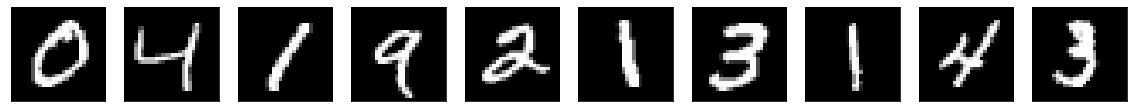

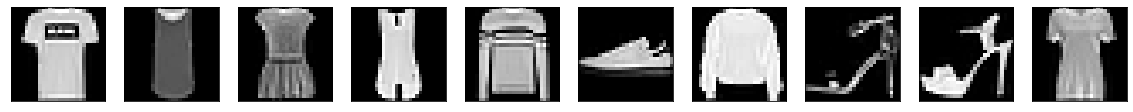

In [3]:
# MNIST
x_train, x_test, y_train, y_test = load_data()
plot_images(x_train)
# fashion MNIST
x_train, x_test, y_train, y_test = load_data(True)
plot_images(x_train)

## Train a "regular" linear model on the original MNIST dataset

As you see below, the simple logistic regression classifier is already very good on this easy task, with a test accuracy of over 92.6%.

In [4]:
# load data and reshape images to regular feature vectors
x_train, x_test, y_train, y_test = load_data(reshape=True)
# train LogReg classifier
clf = LogisticRegression(class_weight='balanced', random_state=1, fit_intercept=True)
clf.fit(x_train, y_train)
# accuracy on test dataset
clf.score(x_test, y_test)

/Users/franzi/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


0.9262

## Train different NN architectures on MNIST

In the code below we define 3 different neural network architectures: a linear FFNN, a FFNN with multiple hidden layers, and a CNN, which is an architecture particularly well suited for image classification tasks.

You will see that the more complex architectures use an additional operation between layers called `Dropout`. This is a regularization technique used for training neural networks, where a certain percentage of the values in the hidden layer representation of a data point are randomly set to zero. You can think of this as the network suffering from a temporary stroke, which forces the neurons learn redundant representations (i.e., such that one neuron can take over for another neuron that was knocked out), which improves generalization.

The linear FFNN has almost the same accuracy (90.5%) as the LogReg model (please note the NNs were only trained for a single epoch!) and the multi-layer FFNN is already better than the LogReg model (95.8%), while the CNN beats them all (98.3%), which is expected since this architecture is designed for the image classification task.

In [5]:
def train_linnn(x_train, y_train_cat, num_classes=10, epochs=1):
    model = Sequential()
    model.add(Dense(num_classes, activation='softmax', input_shape=(784,)))

    model.compile(loss=keras.losses.categorical_crossentropy,
                  optimizer=keras.optimizers.Adadelta(learning_rate=1.),
                  metrics=['accuracy'])

    model.fit(x_train, y_train_cat, epochs=epochs, batch_size=128)
    return model

def train_ffnn(x_train, y_train_cat, num_classes=10, epochs=1):
    model = Sequential()
    model.add(Dense(512, activation='relu', input_shape=(784,)))
    model.add(Dropout(0.2))
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(num_classes, activation='softmax'))

    model.compile(loss=keras.losses.categorical_crossentropy,
                  optimizer=keras.optimizers.Adadelta(learning_rate=1.),
                  metrics=['accuracy'])

    model.fit(x_train, y_train_cat, epochs=epochs, batch_size=128)
    return model

In [6]:
# load data and reshape 
x_train, x_test, y_train, y_test = load_data(reshape=True)
y_train_cat, y_test_cat = convert_cat(y_train, y_test)
# train simple linear model
model = train_linnn(x_train, y_train_cat)
score = model.evaluate(x_test, y_test_cat, verbose=0)
print('Test accuracy:', score[1])
# equivalent evaluation:
# get predictions (as probabilities)
y_pred = model.predict(x_test)
# convert predictions to classes
y_pred_classes = np.argmax(y_pred, axis=1)
print(accuracy_score(y_test, y_pred_classes), "\n")
# train multi-layer FFNN
model = train_ffnn(x_train, y_train_cat)
score = model.evaluate(x_test, y_test_cat, verbose=0)
print('Test accuracy:', score[1])

469/469 [==============================] - 0s 810us/step - loss: 0.6451 - accuracy: 0.8401
Test accuracy: 0.9046000242233276
0.9046
469/469 [==============================] - 2s 4ms/step - loss: 0.2850 - accuracy: 0.9138
Test accuracy: 0.9577999711036682


In [7]:
# CNN classifier
def train_cnn(x_train, y_train_cat, input_shape=(28, 28, 1), num_classes=10, epochs=1):
    # setup CNN
    model = Sequential()
    model.add(Conv2D(32, kernel_size=(3, 3),
                     activation='relu',
                     input_shape=input_shape))
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(num_classes, activation='softmax'))

    model.compile(loss=keras.losses.categorical_crossentropy,
                  optimizer=keras.optimizers.Adadelta(learning_rate=1.),
                  metrics=['accuracy'])
    # train
    model.fit(x_train, y_train_cat, epochs=epochs, batch_size=128)
    return model

In [8]:
x_train, x_test, y_train, y_test = load_data()
y_train_cat, y_test_cat = convert_cat(y_train, y_test)
# train cnn
model = train_cnn(x_train, y_train_cat)
score = model.evaluate(x_test, y_test_cat, verbose=0)
print('Test accuracy:', score[1])

469/469 [==============================] - 32s 68ms/step - loss: 0.2628 - accuracy: 0.9199
Test accuracy: 0.9827


## Test all models on the Fashion MNIST dataset

On the more difficult FMNIST task, the LogReg model has a much lower accuracy of 84.4% compared to the 92.6% achieved on the original MNIST dataset. When trained for only a single epoch, both the linear and multi-layer FFNNs have a lower accuracy than the LogReg model (80.5 and 81.9% respectively) and only the CNN does a bit better (86.5%). 

In [9]:
# load data and reshape images to regular feature vectors
x_train, x_test, y_train, y_test = load_data(True, reshape=True)
y_train_cat, y_test_cat = convert_cat(y_train, y_test)
# train LogReg classifier
clf = LogisticRegression(class_weight='balanced', random_state=1, fit_intercept=True)
clf.fit(x_train, y_train)
print('Test accuracy LogReg:', clf.score(x_test, y_test), "\n")
# train simple linear model
model = train_linnn(x_train, y_train_cat)
score = model.evaluate(x_test, y_test_cat, verbose=0)
print('Test accuracy Linear NN:', score[1], "\n")
# train multi-layer FFNN
model = train_ffnn(x_train, y_train_cat)
score = model.evaluate(x_test, y_test_cat, verbose=0)
print('Test accuracy FFNN:', score[1], "\n")
# load data again (not reshaped)
x_train, x_test, y_train, y_test = load_data(True)
y_train_cat, y_test_cat = convert_cat(y_train, y_test)
# train cnn
model = train_cnn(x_train, y_train_cat)
score = model.evaluate(x_test, y_test_cat, verbose=0)
print('Test accuracy CNN:', score[1])

/Users/franzi/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Test accuracy LogReg: 0.8438
469/469 [==============================] - 0s 781us/step - loss: 0.7530 - accuracy: 0.7527
Test accuracy Linear NN: 0.8045
469/469 [==============================] - 2s 4ms/step - loss: 0.5820 - accuracy: 0.7895
Test accuracy FFNN: 0.8194
469/469 [==============================] - 34s 73ms/step - loss: 0.5575 - accuracy: 0.8024
Test accuracy CNN: 0.8652


However, when trained for more epochs, the performance of all models improves, with the accuracy of the linear FFNN now being very close to that of the LogReg model (84.3%), while the multi-layer FFNN is better (89.3%) and the CNN can now solve the task quite well with an accuracy of 92.4%.

(See how the loss decreases over time - observing how this metric develops can help you judge whether you've set your learning rate correctly.)

In [10]:
x_train, x_test, y_train, y_test = load_data(True, reshape=True)
y_train_cat, y_test_cat = convert_cat(y_train, y_test)
# train simple linear model
model = train_linnn(x_train, y_train_cat, epochs=15)
score = model.evaluate(x_test, y_test_cat, verbose=0)
print('Test accuracy Linear NN:', score[1], "\n")
# train multi-layer FFNN
model = train_ffnn(x_train, y_train_cat, epochs=15)
score = model.evaluate(x_test, y_test_cat, verbose=0)
print('Test accuracy FFNN:', score[1], "\n")
# load data again (not reshaped)
x_train, x_test, y_train, y_test = load_data(True)
y_train_cat, y_test_cat = convert_cat(y_train, y_test)
# train cnn
model = train_cnn(x_train, y_train_cat, epochs=15)
score = model.evaluate(x_test, y_test_cat, verbose=0)
print('Test accuracy CNN:', score[1])

Epoch 1/15
469/469 [==============================] - 0s 785us/step - loss: 0.7222 - accuracy: 0.7677
Epoch 2/15
469/469 [==============================] - 0s 766us/step - loss: 0.5074 - accuracy: 0.8297
Epoch 3/15
469/469 [==============================] - 0s 759us/step - loss: 0.4694 - accuracy: 0.8403
Epoch 4/15
469/469 [==============================] - 0s 832us/step - loss: 0.4507 - accuracy: 0.8480
Epoch 5/15
469/469 [==============================] - 0s 776us/step - loss: 0.4388 - accuracy: 0.8495
Epoch 6/15
469/469 [==============================] - 0s 755us/step - loss: 0.4306 - accuracy: 0.8535
Epoch 7/15
469/469 [==============================] - 0s 772us/step - loss: 0.4239 - accuracy: 0.8544
Epoch 8/15
469/469 [==============================] - 0s 757us/step - loss: 0.4183 - accuracy: 0.8567
Epoch 9/15
469/469 [==============================] - 0s 767us/step - loss: 0.4139 - accuracy: 0.8577
Epoch 10/15
469/469 [==============================] - 0s 750us/step - loss: 0.410